## Only transmon and cavity and chain!

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as linalg
import math
import time

# Parameters
d = 0.35 #squid asymmetry
g = 0.08 #transmon cavity coupling
Wq0 = 3.474 #dressed qubit frequency
Wc0 = 7.192 #dressed cavity frequency
lamb_shift  = g**2/(Wc0 - Wq0)
Wc = Wc0 - lamb_shift #bare cavity
Wq = Wq0 + lamb_shift #bare qubit
g_d = 1


gamma_L = 0.1 # chain coupling to the left josephson junction
gamma_R = gamma_L*(1-d)/(1+d) # chain coupling to the right josephson junction
t = 0.2 # chain hopping
E_C = 0.06 # charging energy
E_J_max = (Wq+E_C)**2/8/E_C
# E_J1 = 1
# E_J2 = E_J1
n_g = 0
N = 3 # number of chain fermions
n_0 = 10 #number of CP
steps = 200
flux_0 = 1 #2.067833*10**(-15)
flux_array = np.linspace(0,flux_0,steps)
num_of_eigen = 4

max_num_photons = 2 #number of photons



# Defining the single spin operators s_x, s_y, s_z:
s_x = 0.5*np.array([[0,1],[1,0]], dtype=complex)
s_y = 0.5*np.array([[0,-1j],[1j,0]], dtype=complex)
s_z = 0.5*np.array([[1,0],[0,-1]], dtype=complex)

s_plus = s_x + 1j*s_y
s_minus = s_x - 1j*s_y

# Defining the creation and annihilation operators for the SCs
exp_phi_plus = np.diag(np.ones(2*n_0, dtype=complex), k=-1) # Creation
exp_phi_minus = np.diag(np.ones(2*n_0, dtype=complex), k=1)# Annihilation

# harmonic osc creation and annihilation
occupation = np.arange(1,max_num_photons+1, dtype=complex)
a_down = np.diag(np.sqrt(occupation), k=1)
a_up = np.diag(np.sqrt(occupation), k=-1)
occupation_operator = a_up @ a_down


In [13]:
n_10 = -1j*(1/np.sqrt(2))*(E_J_max/(8*E_C))**(1/4)
n_10_conj = np.conj(n_10)
n_01 = 1j*(1/np.sqrt(2))*(E_J_max/(8*E_C))**(1/4)
n_01_conj = np.conj(n_01)
print(np.abs(n_10))
print(np.abs(n_10_conj))
# n_10 = np.abs(n_10)
# n_01 = np.abs(n_01)
Wp = np.sqrt(8*E_C*E_J_max)
N_00 = 1/np.sqrt(1+(g*np.abs(n_01)/(Wc+Wp))**2)
N_10 = 1/np.sqrt(1+(g*np.abs(n_10)/(Wc-Wp))**2)
N_01 = 1/np.sqrt(1+(g*np.abs(n_01)/(Wc-Wp))**2+(np.sqrt(2)*g*np.abs(n_01)/(Wc+Wp))**2)
N_11 = 1/np.sqrt(1+(np.sqrt(2)*g*np.abs(n_10)/(Wc-Wp))**2+(g*np.abs(n_10)/(Wc+Wp))**2)
N_02 = 1/np.sqrt(1+(np.sqrt(2)*g*np.abs(n_01)/(Wc-Wp))**2+(np.sqrt(3)*g*np.abs(n_01)/(Wc+Wp))**2)
N_12 = 1/np.sqrt(1+(np.sqrt(2)*g*np.abs(n_10)/(Wc+Wp))**2+(np.sqrt(3)*g*np.abs(n_10)/(Wc-Wp))**2)

M_01 = N_00*N_10*g_d*(-(g*n_01_conj/(Wc+Wp))-(g*n_10/(Wc-Wp)))
print("M_01:", M_01)
M_02 = N_00*N_01*g_d*(1-(g*n_01_conj/(Wc+Wp))*(g*n_01/(Wc-Wp))-(g*n_01_conj/(Wc+Wp))*(-2*g*n_01/(Wc+Wp)))
print("M_02:", M_02)
M_05 = N_00*N_12*g_d*((np.sqrt(2)*g*n_10/(Wc+Wp))-(np.sqrt(2)*g*n_01_conj/(Wc+Wp)))
print("M_05:", M_05)
M_13 = N_10*N_11*g_d*(1-(g*n_10_conj/(Wc-Wp))*(-2*g*n_10/(Wc-Wp))-(g*n_10_conj/(Wc-Wp))*(g*n_10/(Wc+Wp)))
print("M_13:", M_13)
M_14 = N_10*N_02*g_d*((np.sqrt(2)*g*n_01/(Wc-Wp))-(np.sqrt(2)*g*n_10_conj/(Wc-Wp)))
print("M_14:", M_14)
M_23 = N_01*N_11*g_d*(-(2*g*n_10/(Wc-Wp))+(g*n_10/(Wc+Wp))+(g*n_01_conj/(Wc-Wp))-(2*g*n_01_conj/(Wc+Wp)))
print("M_23:", M_23)
M_24 = N_01*N_02*g_d*(np.sqrt(2)+(g*n_01_conj/(Wc-Wp))*(np.sqrt(2)*g*n_01/(Wc-Wp))-(np.sqrt(2)*g*n_01_conj/(Wc+Wp))*(np.sqrt(2)*g*n_01/(Wc-Wp))*np.sqrt(2)-(np.sqrt(2)*g*n_01_conj/(Wc+Wp))*(3*g*n_01/(Wc+Wp)))
print("M_24:", M_24)
M_35 = N_11*N_12*g_d*(np.sqrt(2)-(np.sqrt(2)*g*n_10_conj/(Wc-Wp))*(3*g*n_10/(Wc-Wp))-(np.sqrt(2)*g*n_10_conj/(Wc-Wp))*(np.sqrt(2)*g*n_10/(Wc+Wp))*np.sqrt(2)+(g*n_10_conj/(Wc+Wp))*(np.sqrt(2)*g*n_10/(Wc+Wp)))
print("M_35:", M_35)
M_45 = N_02*N_12*g_d*((2*g*n_10/(Wc+Wp))-(3*g*n_10/(Wc-Wp))+(2*g*n_01_conj/(Wc-Wp))-(3*g*n_01_conj/(Wc+Wp)))
print("M_45:", M_45)

1.9191256026420354
1.9191256026420354
M_01: (-0+0.05626899356342004j)
M_02: (0.9986207914444222+0j)
M_05: 0j
M_13: (1.0001786620379085+0j)
M_14: 0j
M_23: 0.05615848282973401j
M_24: (1.4096861257133892+0j)
M_35: (1.398714079574213+0j)
M_45: 0.05604840532532487j


In [55]:

def H_Transmon(E_C = E_C, n_0 = n_0, n_g = n_g, E_J_max = E_J_max, d = d, flux=0, cutoff_transmon = False, size_of_subspace = None): #N is the number of cp passed from one sc to the other
    # when cutoff = false I return H,eigenvalues,eigenvectors in the size of the whole transmon space
    # when cutoff = true I return H,eigenvalues,eigenvectors. H in the size of the subspace and eigenvalues,eigenvectors in the size of the whole transmon space
    D = np.zeros(2*n_0+1) #this will be the diagonal
    for i in range(2*n_0+1):
        D[i] = 4*E_C*(-n_0+i-n_g)**2
    H = np.diag(D) - (E_J_max/2)*np.sqrt(np.cos(np.pi*flux/flux_0)**2 + (d**2)*np.sin(np.pi*flux/flux_0)**2)*(exp_phi_minus + exp_phi_plus)
    eigenvalues_transmon, eigenvectors_transmon = np.linalg.eigh(H)
    # sort eigenvalues and rearrange corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues_transmon)
    sorted_eigenvalues_transmon = eigenvalues_transmon[sorted_indices]
    sorted_eigenvectors_transmon = eigenvectors_transmon[:, sorted_indices]
    if cutoff_transmon: # slice the wanted subspace
        indices_of_transmon = np.array(range(size_of_subspace))
        A = np.dot(np.dot(np.linalg.inv(sorted_eigenvectors_transmon), H), sorted_eigenvectors_transmon)[indices_of_transmon,:][:,indices_of_transmon]
        #print("the H_trans matrix after u_dag*H*U:", A)
        B = np.sum(np.abs(A-np.conj(A.T)))
        print("hermitian of H_trans u_dag*H*U:", B)
        H = np.diag(sorted_eigenvalues_transmon[indices_of_transmon])
    else:
        H = np.diag(sorted_eigenvalues_transmon)
    return H, sorted_eigenvalues_transmon, sorted_eigenvectors_transmon

def H_cavity(Wc = Wc):
    H = Wc*(a_up @ a_down)
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_cav:", B)
    return H

def H_int_transmon_cavity(g = g, n_0 = n_0, n_g = n_g, cutoff_transmon = False, size_of_subspace = None, U = None): # also added the chain's dimension
    # U is the eigenvector matrix of the transmon
    D = np.zeros(2*n_0+1) #this will be the diagonal
    for i in range(2*n_0+1):
        D[i] = (-n_0+i-n_g)
    D = np.diag(D)
    D = np.dot(np.dot(np.linalg.inv(U), D), U)
    if cutoff_transmon:
        indices_of_transmon = np.array(range(size_of_subspace))
        D = D[indices_of_transmon,:][:,indices_of_transmon]
        # D = np.where(np.abs(D)<1e-14,0,D)
    H = g*np.kron(D,np.kron((a_down+a_up), np.identity(2**N, dtype=complex)))
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_int_trans_cav:", B)
    return H

def H_Chain(N = N, t = t): # the hamiltonian of the chain alone. N is the number of spins in the system (when we count the up and down spins). t is the tunneling constant
    H_C = np.zeros((2**N,2**N), dtype=complex)
    if N < 3 :
        return np.zeros((2**N, 2**N))
    for i in range(0, N-2, 1):
        term = np.kron(np.identity(2**(i-1+1), dtype=complex),np.kron(s_plus,np.kron(-s_z, np.kron(s_minus,np.identity(2**(N-(i+2+1)), dtype=complex)))))
        H_C += term + term.conj().T # I am adding +1 in all the dimensions because the range starts from 0 and the spin index start from 1
    B = np.sum(np.abs(H_C-np.conj(H_C.T)))
    print("hermitian of H_Chain:", B)
    return -t*H_C

def H_int_transmon_chain(N = N, gamma_L = gamma_L, gamma_R = gamma_R, flux = 0, cutoff_transmon = False, size_of_subspace = None, U = None):
    exp_plus = np.exp(1j*np.pi*flux/(2*flux_0)) # should be next to phi_L and -phi_R
    exp_minus = np.conj(exp_plus) # should be next to -phi_L and phi_R
    exp_phi_plus_1 = np.dot(np.dot(np.linalg.inv(U), exp_phi_plus), U) # basis transformation to the transmon eigenspace
    if N < 2:
        if cutoff_transmon:
            return np.zeros(((size_of_subspace)*(max_num_photons+1)*2**N, (size_of_subspace)*(max_num_photons+1)*2**N), dtype=complex)
        else:
            return np.zeros(((2*n_0+1)*(max_num_photons+1)*2**N, (2*n_0+1)*(max_num_photons+1)*2**N), dtype=complex)
    if cutoff_transmon:
        indices_of_transmon = np.array(range(size_of_subspace))
        exp_phi_plus_1 = exp_phi_plus_1[indices_of_transmon,:][:,indices_of_transmon]
    left_term = np.kron(exp_plus*exp_phi_plus_1, np.kron(np.identity((max_num_photons+1), dtype=complex),np.kron(s_minus,np.kron(s_minus, np.identity(2**(N-2), dtype=complex)))))
    right_term = np.kron(exp_minus*exp_phi_plus_1, np.kron(np.identity((max_num_photons+1), dtype=complex), np.kron(np.identity(2**(N-2), dtype=complex),np.kron(s_minus, s_minus))))
    H_int = gamma_L * (left_term + left_term.conj().T) + gamma_R * (right_term + right_term.conj().T)
    B = np.sum(np.abs(H_int-np.conj(H_int.T)))
    print("hermitian of H_int_trans_chain:", B)
    return H_int

def H_total(flux, cutoff_transmon = False, size_of_subspace = None):
    H_T = H_Transmon(flux=flux, cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace)
    U = H_T[2]
    if cutoff_transmon:
        H = np.kron(H_T[0], np.kron(np.identity((max_num_photons+1)), np.identity((2**N))))\
            + np.kron(np.identity(size_of_subspace), np.kron(H_cavity(), np.identity((2 ** N))))\
            + H_int_transmon_cavity(cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace,U=U)\
            + np.kron(np.identity(size_of_subspace), np.kron(np.identity((max_num_photons+1)), H_Chain()))\
            + H_int_transmon_chain(flux=flux,cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace,U=U)
    else:
        H = np.kron(H_T[0], np.kron(np.identity((max_num_photons+1)), np.identity((2**N))))\
            + np.kron(np.identity((2*n_0+1)), np.kron(H_cavity(), np.identity((2**N))))\
            + H_int_transmon_cavity(U=U)\
            + np.kron(np.identity((2*n_0+1)), np.kron(np.identity((max_num_photons+1)), H_Chain()))\
            + H_int_transmon_chain(flux=flux,U=U)
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_3:", B)
    return H



# test to verify my matrix
# H = H_3(flux[2])
# A = np.sum(np.abs(H - np.conj(H.T)))
# print(A)

n_total = (2*n_0+1)*(max_num_photons+1)*(2**N)

def eigen_for_each_flux(flux_array, cutoff_transmon = False, size_of_subspace = None):
    n_total_1 = n_total
    if cutoff_transmon:
        n_total_1 = size_of_subspace*(max_num_photons+1)*(2**N)
    eigenvalues_sys = np.zeros((steps,n_total_1), dtype=complex) # we have num of rows in the size of steps and columns in the size of (2*n_0+1)*(max_num_photons+1)*(2**N). each row contains all the eigenvalues for specific flux, so each column is a specific eigenvalue for diff fluxes.
    eigenvectors_sys = np.zeros((steps,n_total_1,n_total_1), dtype=complex)# first dim is steps of flux, 2nd and 3rd dims are for the eigenvectors. so if numpy returns the eigenvectors as a matrix where each column corresponds to eigen-energy, dim 2 is the rows of the matrix and dim 3 is the columns.
    tic = time.time()
    for i in range(steps):
        if cutoff_transmon:
            H = H_total(flux = flux_array[i],cutoff_transmon=cutoff_transmon,size_of_subspace=size_of_subspace)
        else:
            H = H_total(flux = flux_array[i])
        current_eigenvalues, current_eigenvectors = np.linalg.eigh(H)
        print(i)
        # sort eigenvalues and rearrange corresponding eigenvectors
        sorted_indices = np.argsort(current_eigenvalues)
        sorted_eigenvalues = current_eigenvalues[sorted_indices]
        sorted_eigenvectors = current_eigenvectors[:, sorted_indices]
        # store results
        eigenvalues_sys[i,:] = sorted_eigenvalues-sorted_eigenvalues[0] # the difference from the GS
        eigenvectors_sys[i,:,:] = sorted_eigenvectors
    toc = time.time()
    print(f"time {toc - tic}s")
    return eigenvalues_sys, eigenvectors_sys


cutoff = True
size_of_transom_subspace = 2
eigenvalues_sys, eigenvectors_sys = eigen_for_each_flux(flux_array,cutoff_transmon=cutoff,size_of_subspace=size_of_transom_subspace)
eigenvalues_diff_from_GS = eigenvalues_sys - eigenvalues_sys[:,0][:, np.newaxis] #np.newaxis is used to increase the dimension of the existing array by one more dimension when used in array indexing or slicing. so here i slice the first column (numpy makes it a row array) and then reshape it to be 2d so i can use broadcasting.

# Save eigenvalues and eigenvectors
filename_eigenvalues = f'eigenvalues_sys_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transom_subspace}.npy'
np.save(filename_eigenvalues, eigenvalues_sys)
filename_eigenvectors = f'eigenvectors_sys_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transom_subspace}.npy'
np.save(filename_eigenvectors, eigenvectors_sys)

# subspace = 5
# H_1 = H_Transmon(flux = np.pi*flux_0)
# print("H1:", H_1[0])
# H_2 = H_Transmon(flux = np.pi*flux_0, cutoff_transmon=True, size_of_subspace=subspace)
# print("H2:", H_2[0]) #, "eigenvalues_transmon:", eigenvalues_transmon, "eigenvectors_transmon:", eigenvectors_transmon)
# U = H_2[2]
# H_int = H_int_transmon_cavity(cutoff_transmon=True, size_of_subspace=subspace, U=U)
# print(H_int)

hermitian of H_trans u_dag*H*U: 3.228556716671327e-15
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 3.552713678800501e-15
hermitian of H_Chain: 0.0
hermitian of H_int_trans_chain: 0.0
hermitian of H_3: 3.552713678800501e-15
0
hermitian of H_trans u_dag*H*U: 4.704927205752408e-15
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 1.7763568394002505e-15
hermitian of H_Chain: 0.0
hermitian of H_int_trans_chain: 0.0
hermitian of H_3: 1.7763568394002505e-15
1
hermitian of H_trans u_dag*H*U: 1.1464077642909275e-14
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 2.6645352591003757e-15
hermitian of H_Chain: 0.0
hermitian of H_int_trans_chain: 0.0
hermitian of H_3: 2.6645352591003757e-15
2
hermitian of H_trans u_dag*H*U: 7.041686733072224e-15
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 6.217248937900877e-15
hermitian of H_Chain: 0.0
hermitian of H_int_trans_chain: 0.0
hermitian of H_3: 6.217248937900877e-15
3
hermitian of H_trans u_dag*H*U: 3.1612474352711215e-15
herm

### Calculate the eigenvectors of the transmon alone and the cavity alone

## Plot of the differences from the GS

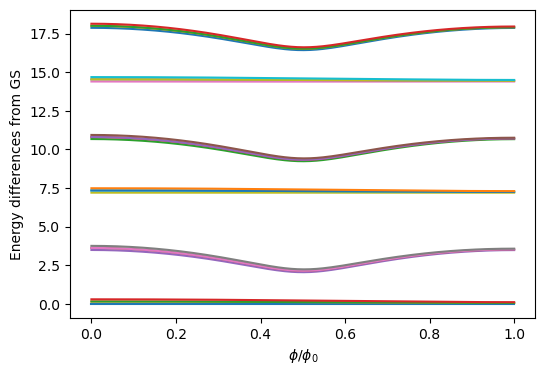

[ 0.        +0.j  0.10487061+0.j  0.10487061+0.j  0.20846584+0.j
  2.04294635+0.j  2.13384472+0.j  2.13384472+0.j  2.22601754+0.j
  7.19144312+0.j  7.29630441+0.j  7.29630441+0.j  7.39989201+0.j
  9.23206492+0.j  9.32297259+0.j  9.32297259+0.j  9.41515302+0.j
 14.38727762+0.j 14.49213625+0.j 14.49213625+0.j 14.59572173+0.j
 16.42906313+0.j 16.51995882+0.j 16.51995882+0.j 16.61212949+0.j]
24
10


In [29]:
def plot_diff_from_GS():
    fig = plt.figure(figsize=(6, 4))
    energies = 6*2**N
    for i in range(energies):
        plt.plot(flux_array,np.real(eigenvalues_diff_from_GS[:,i]))

    plt.xlabel(r'${\phi}/{\phi_0}$')
    plt.ylabel('Energy differences from GS')
    # plt.title('Energy differences from GS (asymmetric transmon, cavity and chain)')

    # Save the figure as an image (e.g., PNG)
    filename = f'diff_from_GS_amount_of_energies_{energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}_Transmon_cutoff_{cutoff}_{size_of_transom_subspace}.png'
    plt.savefig(filename)

    # plt.legend()
    plt.show()
    print(eigenvalues_sys[100,:])
    print(eigenvalues_sys.shape[1])

plot_diff_from_GS()
print(n_0)

Now I want to plot the difference between any two energies as a function of the flux E_i-E_j when E_i > E_j. also I want to add a color bar and paint the lines in the graph by the transition probability between the levels i and j that is caused from the transmon-cavity coupling meaning the term (a_down+a_up).
I will first create the transition amplitude matrix - M.

## Adding a plot of s(w,phi) in 2d plot - Second order FGR

In [56]:
amount_of_energies = eigenvalues_sys.shape[1] #6*2**N
amount_of_energy_diff = np.sum(list(range(amount_of_energies)))

def create_M_and_delta():
    delta_energy = np.zeros((steps,amount_of_energies,amount_of_energies), dtype=complex) # contains the energy differences, 0 axies in the size of flux array, 1 axies and 2 axies in size of amount of energies. so in each [:,i,j] i will the diff E_i-E_j
    M = np.zeros_like(delta_energy, dtype=complex) # contains the transition probability due to a_down + a_up, here i will put the probabilities. It will contain <i|a_down+a_up|j> in the i'th row and j'th column

    if cutoff:
        operator_2 = np.kron(np.identity(size_of_transom_subspace), np.kron(g_d*(a_down+a_up), np.identity(2**N))) # that's the operator I want to get the transition probability for
    else:
        operator_2 = np.kron(np.identity((2*n_0+1)), np.kron(g_d*(a_down+a_up), np.identity(2**N))) # that's the operator I want to get the transition probability for

    print("operator should be of total dimension:", operator_2.shape) # sanity test

    for i in range(amount_of_energies): # a loop that iterates from 0 to 6 including
        print("i =", i)
        for j in range(amount_of_energies): # a loop that iterates from 0 to 6 including
            diff = eigenvalues_sys[:,i] - eigenvalues_sys[:,j] # should be an array with number of rows as "steps" (and flux_array) and one column
            delta_energy[:,i,j] = diff
            temp_expectation_vec = np.zeros((steps,1), dtype=complex)
            for step in range(steps):
                vec_i = eigenvectors_sys[step,:,i]
                vec_j = eigenvectors_sys[step,:,j]
                M_ij = vec_i.conj().dot(operator_2.dot(vec_j))# here I want to save the transition probability from j to i for each step because each step have different eigenvectors
                M[step,i,j] = M_ij
    return M, delta_energy

M, delta_energy = create_M_and_delta()
M = np.abs(M)
delta_energy = np.abs(delta_energy)
# delta_energy = np.real(delta_energy)
print(M.shape)
print(delta_energy.shape)
print("are the eigenvalues complex?:",np.iscomplex(eigenvalues_sys).any())


operator should be of total dimension: (48, 48)
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
(200, 48, 48)
(200, 48, 48)
are the eigenvalues complex?: False


(200, 1128)


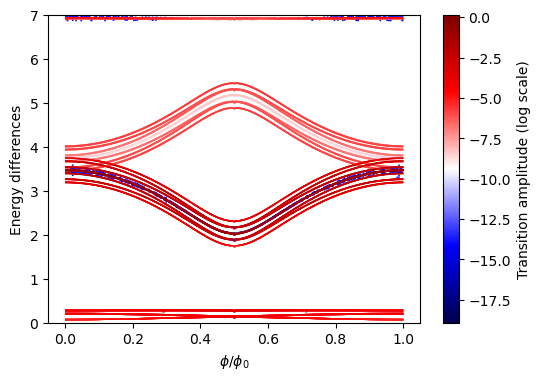

In [59]:

from matplotlib import colors
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection

# M and delta energy are (200,7,7) mat where each layer is <i|a_up+a_down|j> i want to get only the upper triangle of each layer (k=1) and make it 1D and put in a matrix of (200,21)
M_wo_numerical_err = np.where(M<1e-14,None,M)

def draw_energy_diff_color_FGR(M_wo_numerical_err):
    M_temp = np.zeros((steps,amount_of_energy_diff))
    print(M_temp.shape)
    delta_energy_temp = np.zeros_like(M_temp)
    upper_triangle_indices = np.triu_indices(M_wo_numerical_err.shape[1],k=1)
    for i in range(M_wo_numerical_err.shape[0]):
        upper_triangle = M_wo_numerical_err[i][upper_triangle_indices]
        M_temp[i,:] = upper_triangle
        delta_energy_temp[i,:] = np.abs(delta_energy[i][upper_triangle_indices])

    norm = colors.Normalize(vmin=np.min(np.log10(M)),vmax=np.max(np.log10(M))) # normalizes the M values to 0-1
    cmap = get_cmap('seismic')
    fig, ax = plt.subplots(figsize=(6, 4)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)
    for i in range(0, amount_of_energy_diff):
        points = np.array([flux_array, delta_energy_temp[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
        segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
        lc.set_array(np.log10(M_temp[:,i])) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
        ax.add_collection(lc) # add the linecollection to the ax
        if i == 0:
            # Adding colorbar to show the color scale
            cb = plt.colorbar(lc, ax=ax)
            cb.set_label('Transition amplitude (log scale)')
    ax.autoscale() #adjusts the axis limits to fit the data in the subplot
    plt.xlabel(r'${\phi}/{\phi_0}$')
    plt.ylabel('Energy differences')
    # plt.title('Energy differences (asymmetric transmon and cavity)')
    plt.ylim(0, 7)

    # Save the figure as an image (e.g., PNG)
    filename = f'wo_errors_FGR_amount_of_energies_{amount_of_energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}.png'
    plt.savefig(filename)
    plt.show()
    return M_temp, delta_energy_temp

M_temp, delta_energy_temp = draw_energy_diff_color_FGR(M_wo_numerical_err)

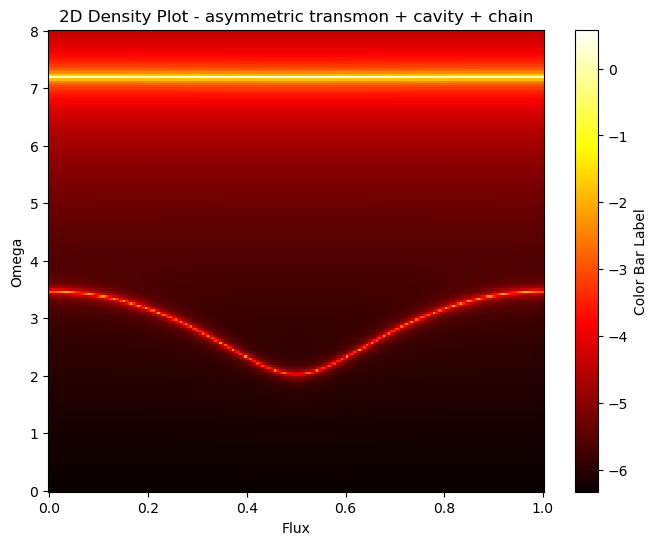

In [6]:
# Generate the flux and omega arrays
omega_array = np.linspace(0,8,num = 200)
kapa = 0.002
T = 1.6669 #80mK in GHz
# Create a meshgrid of flux and omega values
flux_grid, omega_grid = np.meshgrid(np.pi*flux_array, omega_array)

# Define a function that computes the color value based on flux and omega
def color_function(flux, omega): # flux and omega are 2d arrays where the y-axis (0 axis - rows) is the size of omega_array and the x-axis (1 axis - columns) is the size of flux_array.
    s = np.zeros_like(flux)
    for i in range(omega.shape[0]):
        for j in range(flux.shape[1]):
            temp_s = 0
            for k in range(M_temp.shape[1]):
                temp_s += (M_temp[j,k]**2)*(kapa**2)/((delta_energy_temp[j,k]-omega[i,j])**2 + kapa**2)
            s[i,j] = temp_s
    return s

# Compute the color values for each combination of flux and omega. This is a 2d array of size omega_array X flux_array
color_values = color_function(flux_grid, omega_grid)

# Create a 2D density plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(flux_array, omega_array, np.log10(color_values), cmap='hot')  # Adjust the colormap as needed
plt.colorbar(label='Color Bar Label')  # Add a color bar for reference
plt.xlabel('Flux')
plt.ylabel('Omega')
plt.title('2D Density Plot - asymmetric transmon + cavity + chain')

# Save the figure as an image (e.g., PNG)
filename = f'density_s(w,phi)_amount_of_energies_{amount_of_energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_Transmon_cutoff_{cutoff}_{size_of_transom_subspace}.png'
plt.savefig(filename)

plt.show()


### This is second order only!


In [84]:
# Generate the flux and omega arrays
omega_array = np.linspace(0,8,num = 200)
kapa = 0.002
epsilon = 0.00001
# Create a meshgrid of flux and omega values
flux_grid_2, omega_grid_2 = np.meshgrid(np.pi*flux_array, omega_array)

# Define a function that computes the color value based on flux and omega
def color_function(flux, omega): # flux and omega are 2d arrays where the y-axis (0 axis - rows) is the size of omega_array and the x-axis (1 axis - columns) is the size of flux_array.
    s = np.zeros_like(flux)
    for o in range(omega.shape[0]): #amount of omegas
        print("omega =", o)
        for j in range(flux.shape[1]): #amount of fluxes
            temp = 0
            for f in range(M.shape[1]): #axis 1 of M is the amount of energies (ie. 7) rows
                for i in range(M.shape[2]): #axis 2 of M is the amount of energies (ie. 7) columns
                    temp_m = 0
                    for m in range(M.shape[2]):
                        if m!=i or m!=f:
                            temp_m += (M[j,f,m]*M[j,m,i])/((delta_energy[j,m,i]-omega[o,j])-1j*epsilon)
                    temp += np.abs(temp_m)**2*(kapa**2)/((delta_energy[j,f,i]-2*omega[o,j])**2 + kapa**2)
            s[o,j] = 2*np.pi*temp
    return s


# Compute the color values for each combination of flux and omega. This is a 2d array of size omega_array X flux_array
color_values = color_function(flux_grid_2, omega_grid_2)

# Create a 2D density plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(flux_array, omega_array, np.log10(color_values), cmap='hot')  # Adjust the colormap as needed
plt.colorbar(label='Color Bar Label')  # Add a color bar for reference
plt.xlabel('Flux')
plt.ylabel('Omega')
plt.title('2D Density Plot Second order FGR - asymmetric transmon + cavity')

# Save the figure as an image (e.g., PNG)
filename = f'second_order_FGR_s(w,phi)_amount_of_energies_{amount_of_energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}.png'
plt.savefig(filename)

plt.show()


omega = 0


C:\Users\User\AppData\Local\Temp\ipykernel_9692\2764386354.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  s[o,j] = 2*np.pi*temp


omega = 1
omega = 2
omega = 3


KeyboardInterrupt: 

## Painting the energy difference plot with the second order values of FGR

are the delta energy complex?: False
(200, 36)
(200, 36)


C:\Users\User\AppData\Local\Temp\ipykernel_9692\4160256862.py:27: RuntimeWarning: divide by zero encountered in log10
  norm = colors.Normalize(vmin=np.min(np.log10(FGR2)),vmax=np.max(np.log10(FGR2))) # normalizes the M values to 0-1
C:\Users\User\AppData\Local\Temp\ipykernel_9692\4160256862.py:37: RuntimeWarning: divide by zero encountered in log10
  lc.set_array(np.log10(FGR2[:,i])) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection


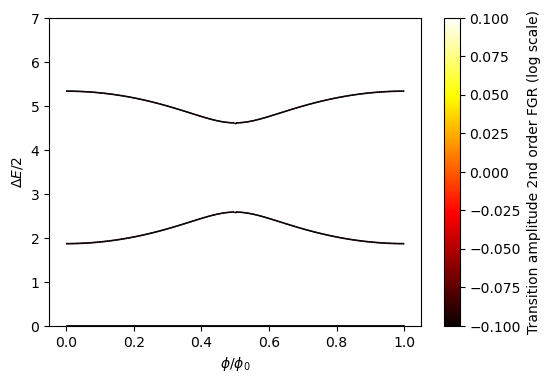

In [96]:
delta_energy_postive = np.where(delta_energy<0, 0, delta_energy)
epsilon = 0.00001

def draw_energy_diff_color_2nd_FGR(M_wo_numerical_err):
    # M_temp = np.zeros((steps,amount_of_energy_diff))
    # print(M_temp.shape)
    # delta_energy_temp = np.zeros_like(M_temp)
    # upper_triangle_indices = np.triu_indices(M.shape[1],k=1)
    # for i in range(M.shape[0]):
    #     upper_triangle = M[i][upper_triangle_indices]
    #     upper_triangle = M[i][upper_triangle_indices]
    #     M_temp[i,:] = upper_triangle
    #     delta_energy_temp[i,:] = delta_energy[i][upper_triangle_indices]

    FGR2 = np.zeros_like(M_wo_numerical_err, dtype=complex)
    delta_energy_div_2 = delta_energy_postive/2

    for f in range(M_wo_numerical_err.shape[1]): #axis 1 of M is the amount of energies (ie. 7) rows
        for i in range(M_wo_numerical_err.shape[2]): #axis 2 of M is the amount of energies (ie. 7) columns
            for m in range(M_wo_numerical_err.shape[2]):
                if m!=i and m!=f:
                    FGR2[:,f,i] +=(M_wo_numerical_err[:,f,m]*M_wo_numerical_err[:,m,i])/((delta_energy[:,m,i]-delta_energy_postive[:,f,i]/2)-1j*epsilon)
    FGR2 = np.abs(FGR2)**2
    FGR2 = FGR2.reshape((FGR2.shape[0], -1))
    delta_energy_div_2 = delta_energy_div_2.reshape((delta_energy_div_2.shape[0], -1))
    print("are the delta energy complex?:",np.iscomplex(delta_energy_div_2).any())
    norm = colors.Normalize(vmin=np.min(np.log10(FGR2)),vmax=np.max(np.log10(FGR2))) # normalizes the M values to 0-1
    cmap = get_cmap('hot')
    fig, ax = plt.subplots(figsize=(6, 4)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)
    print(delta_energy_div_2.shape)
    print(FGR2.shape)

    for i in range(delta_energy_div_2.shape[1]):
        points = np.array([flux_array, delta_energy_div_2[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
        segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
        lc.set_array(np.log10(FGR2[:,i])) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
        ax.add_collection(lc) # add the linecollection to the ax
        if i == 0:
            # Adding colorbar to show the color scale
            cb = plt.colorbar(lc, ax=ax)
            cb.set_label('Transition amplitude 2nd order FGR (log scale)')
    ax.autoscale() #adjusts the axis limits to fit the data in the subplot
    plt.xlabel(r'${\phi}/{\phi_0}$')
    plt.ylabel(r'${\Delta}E/2$')
    # plt.title('Energy differences (asymmetric transmon and cavity)')
    plt.ylim(0, 7)

    # Save the figure as an image (e.g., PNG)
    filename = f'2nd_order_FGR_amount_of_energies_{amount_of_energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}_t_{t}.png'
    plt.savefig(filename)
    plt.show()

draw_energy_diff_color_2nd_FGR(M_wo_numerical_err)